In [8]:
import sys
sys.path.append('..')

from ultralytics import YOLO
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import cv2
import os
from pathlib import Path
import torch

from shapes import Rectangle
from optimization import read_bboxes
%matplotlib inline

In [9]:
ds_path = "/home/anna/Datasets/created/pool-form1_pool-3-channels_random/"
yaml = "pool-form1_pool-3-channels_random.yaml"

# YOLO BUILTIN FUNCTION

In [10]:
# Load model
model = YOLO("pool-form1_pool-3-channels_random_best.pt")
results = model.val(data=f"{ds_path}/{yaml}")
ap50_yolo = results.results_dict["metrics/mAP50(B)"] # AP50
print(results.results_dict)

print(f"AP50: {ap50_yolo:.4f}")

Ultralytics 8.3.74 🚀 Python-3.8.20 torch-2.4.1+cu121 CPU (13th Gen Intel Core(TM) i7-13700H)
YOLOv10n summary (fused): 285 layers, 2,694,806 parameters, 0 gradients, 8.2 GFLOPs


val: Scanning /home/anna/Datasets/created/pool-form1_pool-3-channels_random/labels/val.cache... 1 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1/1 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.00it/s]


                   all          1         18      0.898        0.5      0.634      0.325
Speed: 1.3ms preprocess, 63.0ms inference, 0.0ms loss, 0.1ms postprocess per image
Results saved to runs/detect/val36
{'metrics/precision(B)': 0.8982479758936881, 'metrics/recall(B)': 0.5, 'metrics/mAP50(B)': 0.6341518534190251, 'metrics/mAP50-95(B)': 0.32504902901207816, 'fitness': 0.3559593114527728}
AP50: 0.6342


In [11]:
def get_data(ds_path):
    images = os.listdir(os.path.join(ds_path, "images", "val"))

    gt_boxes_all_images = []
    pred_boxes_all_images = []

    for image in images:
        # Get predictions
        prediction = model.predict(os.path.join(ds_path, "images", "val", image), verbose=False)

        pred_boxes = []
        for result in prediction:
            for box in result.boxes.xyxy.cpu().numpy():
                pred_boxes.append(Rectangle(*box[:4].tolist()))  # Pobierz tylko bbox [x1, y1, x2, y2]
            for box, conf in zip(pred_boxes, prediction[0].boxes.conf):
                box.label = conf.item()

        pred_boxes_all_images.append(pred_boxes)

        # Get ground truth
        gt_boxes = read_bboxes(os.path.join(ds_path, "labels", "val", image.replace(".png", ".txt")), prediction[0].orig_shape[1], prediction[0].orig_shape[0])
        gt_boxes_all_images.append(gt_boxes)
    return pred_boxes_all_images, gt_boxes_all_images

def get_tp(pred_boxes, gt_boxes, iou_threshold):

    tp = [0] * len(pred_boxes)
    fp = [0] * len(pred_boxes)
    matched_gt = set()  # Śledzi przypisane GT

    # Sortowanie predykcji 
    sorted_pred_boxes = sorted(pred_boxes, key=lambda x: x.label, reverse=True)

    for i, pred_box in enumerate(sorted_pred_boxes):
        best_iou = 0
        best_gt_idx = -1

        for j, gt_box in enumerate(gt_boxes):
            if j in matched_gt:
                continue  # GT już przypisany

            iou_value = gt_box.iou(pred_box)
            if iou_value > best_iou:
                best_iou = iou_value
                best_gt_idx = j

        if best_iou >= iou_threshold:
            tp[i] = 1
            matched_gt.add(best_gt_idx)
        else:
            fp[i] = 1

    conf = np.array([box.label for box in pred_boxes])

    return np.array(tp), np.array(fp), conf


def show_pr_curves(p, r, p_values = None):
    plt.subplots(1,3, figsize=(15,5))
    plt.subplot(1,3,1)
    if p_values is not None:
        plt.plot(p_values)
    else:
        plt.plot(r, p)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall curve")
    # plt.xlim(0, 1.01)
    # plt.ylim(0, 1.01)

    plt.subplot(1,3,2)
    plt.plot(p)
    plt.xlabel("Confidence threshold")
    plt.ylabel("Precision")
    plt.title("Precision")
    plt.ylim(0, 1.01)

    plt.subplot(1,3,3)
    plt.plot(r)
    plt.xlabel("Confidence threshold")
    plt.ylabel("Recall")
    plt.title("Recall")
    plt.ylim(0, 1.01)
    plt.show()

In [12]:
def get_iou_matrix(gt_boxes, pred_boxes):
    iou = torch.zeros((len(pred_boxes), len(gt_boxes)))
    for i, pred_box in enumerate(pred_boxes):
        for j, gt_box in enumerate(gt_boxes):
            iou[i, j] = pred_box.iou(gt_box)
    return iou

def match_predictions(
       n_preds: torch.Tensor, iou: torch.Tensor, iouv = torch.tensor([0.5]) 
    ) -> torch.Tensor:
        """
        Match predictions to ground truth objects using IoU.

        Args:
            pred_classes (torch.Tensor): Predicted class indices of shape (N,).
            true_classes (torch.Tensor): Target class indices of shape (M,).
            iou (torch.Tensor): An NxM tensor containing the pairwise IoU values for predictions and ground truth.
            use_scipy (bool): Whether to use scipy for matching (more precise).

        Returns:
            (torch.Tensor): Correct tensor of shape (N, 10) for 10 IoU thresholds.
        """
        correct = np.zeros((n_preds, iouv.shape[0])).astype(bool)
        iou = iou.cpu().numpy()
        for i, threshold in enumerate(iouv.tolist()):
            matches = np.nonzero(iou >= threshold)  # IoU > threshold and classes match
            matches = np.array(matches).T
            if matches.shape[0]:
                if matches.shape[0] > 1:
                    matches = matches[iou[matches[:, 0], matches[:, 1]].argsort()[::-1]]
                    matches = matches[np.unique(matches[:, 1], return_index=True)[1]]
                    # matches = matches[matches[:, 2].argsort()[::-1]]
                    matches = matches[np.unique(matches[:, 0], return_index=True)[1]]
                correct[matches[:, 1].astype(int), i] = True
        return torch.tensor(correct, dtype=torch.bool)

# BASIC FUNCTION NO INTERPOLATION

In [13]:
def calculate_ap_basic(gt_boxes, pred_boxes, iou_threshold=0.5, verb=False):
    """
    Calculate Average Precision (AP) for a single IoU threshold for one class.
    Assumes that the predictions have confidence values in `x.label`.
    """
    
    tp, fp, _ = get_tp(pred_boxes, gt_boxes, iou_threshold)

    # Precision and recall for 1000 confidence thresholds
    num_points = 1000
    x = np.linspace(0, 1, num_points)
    p_curve = np.zeros(num_points)
    r_curve = np.zeros(num_points)

    confidences = np.array([box.label for box in pred_boxes])

    for i, conf_threshold in enumerate(x):
        # Filtruj detekcje na podstawie progu confidence
        fp_filtered = fp[confidences >= conf_threshold].sum()
        tp_filtered = tp[confidences >= conf_threshold].sum()
        
        # Precyzja i przypomnienie dla aktualnego progu
        p_curve[i] = tp_filtered / (tp_filtered + fp_filtered) if tp_filtered + fp_filtered > 0 else 1
        r_curve[i] = tp_filtered / len(gt_boxes) if gt_boxes else np.zeros(len(pred_boxes))

    # Obliczenie AP jako suma powierzchni pod wykresem precision-recall
    r_curve = np.concatenate(([1], r_curve, [0]))
    p_curve = np.concatenate(([0], p_curve, [1]))
    ap = -np.sum((r_curve[1:] - r_curve[:-1]) * p_curve[:-1])

    if verb:
        show_pr_curves(p_curve, r_curve)

    return ap

# FROM ULTRALYTICS

In [14]:
def compute_ap(recall, precision):
    """
    Compute the average precision (AP) given the recall and precision curves.

    Args:
        recall (list): The recall curve.
        precision (list): The precision curve.

    Returns:
        (float): Average precision.
        (np.ndarray): Precision envelope curve.
        (np.ndarray): Modified recall curve with sentinel values added at the beginning and end.
    """
    # Append sentinel values to beginning and end
    mrec = np.concatenate(([0.0], recall, [1.0]))
    mpre = np.concatenate(([1.0], precision, [0.0]))

    # Compute the precision envelope
    mpre = np.flip(np.maximum.accumulate(np.flip(mpre)))

    # Integrate area under curve
    method = "interp"  # methods: 'continuous', 'interp'
    if method == "interp":
        x = np.linspace(0, 1, 101)  # 101-point interp (COCO)
        ap = np.trapz(np.interp(x, mrec, mpre), x)  # integrate
    else:  # 'continuous'
        i = np.where(mrec[1:] != mrec[:-1])[0]  # points where x-axis (recall) changes
        ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])  # area under curve

    return ap, mpre, mrec


def ap_per_class_ultralytics(
    tp, conf, pred_cls, target_cls, plot=False, on_plot=None, save_dir=Path(), names={}, eps=1e-16, prefix=""
):
    """
    Compute the average precision per class for object detection evaluation.

    Args:
        tp (np.ndarray): Binary array indicating whether the detection is correct (True) or not (False).
        conf (np.ndarray): Array of confidence scores of the detections.
        pred_cls (np.ndarray): Array of predicted classes of the detections.
        target_cls (np.ndarray): Array of true classes of the detections.
        plot (bool, optional): Whether to plot PR curves or not.
        on_plot (func, optional): A callback to pass plots path and data when they are rendered.
        save_dir (Path, optional): Directory to save the PR curves.
        names (dict, optional): Dict of class names to plot PR curves.
        eps (float, optional): A small value to avoid division by zero.
        prefix (str, optional): A prefix string for saving the plot files.

    Returns:
        tp (np.ndarray): True positive counts at threshold given by max F1 metric for each class.
        fp (np.ndarray): False positive counts at threshold given by max F1 metric for each class.
        p (np.ndarray): Precision values at threshold given by max F1 metric for each class.
        r (np.ndarray): Recall values at threshold given by max F1 metric for each class.
        f1 (np.ndarray): F1-score values at threshold given by max F1 metric for each class.
        ap (np.ndarray): Average precision for each class at different IoU thresholds.
        unique_classes (np.ndarray): An array of unique classes that have data.
        p_curve (np.ndarray): Precision curves for each class.
        r_curve (np.ndarray): Recall curves for each class.
        f1_curve (np.ndarray): F1-score curves for each class.
        x (np.ndarray): X-axis values for the curves.
        prec_values (np.ndarray): Precision values at mAP@0.5 for each class.
    """
    # Sort by objectness
    i = np.argsort(-conf)
    tp, conf, pred_cls = tp[i], conf[i], pred_cls[i]

    # Find unique classes
    unique_classes, nt = np.unique(target_cls, return_counts=True)
    nc = unique_classes.shape[0]  # number of classes, number of detections

    # Create Precision-Recall curve and compute AP for each class
    x, prec_values = np.linspace(0, 1, 1000), []

    # Average precision, precision and recall curves
    ap, p_curve, r_curve = np.zeros((nc, tp.shape[1])), np.zeros((nc, 1000)), np.zeros((nc, 1000))
    for ci, c in enumerate(unique_classes):
        i = pred_cls == c
        n_l = nt[ci]  # number of labels
        n_p = i.sum()  # number of predictions
        if n_p == 0 or n_l == 0:
            continue

        # Accumulate FPs and TPs
        fpc = (1 - tp[i]).cumsum(0)
        tpc = tp[i].cumsum(0)

        # Recall
        recall = tpc / (n_l + eps)  # recall curve
        r_curve[ci] = np.interp(-x, -conf[i], recall[:, 0], left=0)  # negative x, xp because xp decreases

        # Precision
        precision = tpc / (tpc + fpc)  # precision curve
        p_curve[ci] = np.interp(-x, -conf[i], precision[:, 0], left=1)  # p at pr_score

        # AP from recall-precision curve
        for j in range(tp.shape[1]):
            ap[ci, j], mpre, mrec = compute_ap(recall[:, j], precision[:, j])
            if j == 0:
                prec_values.append(np.interp(x, mrec, mpre))  # precision at mAP@0.5

    prec_values = np.array(prec_values) if prec_values else np.zeros((1, 1000))  # (nc, 1000)

    # Compute F1 (harmonic mean of precision and recall)
    names = [v for k, v in names.items() if k in unique_classes]  # list: only classes that have data
    names = dict(enumerate(names))  # to dict
    if plot:
        show_pr_curves(p_curve[0], r_curve[0], prec_values[0])

    return ap

# Moje z interpolacją

In [15]:
def calculate_ap(gt_boxes, pred_boxes, iou_threshold, verb=False):
    tp, fp, conf = get_tp(pred_boxes, gt_boxes, iou_threshold)

    # Sort by objectness
    i = np.argsort(-conf)
    tp, conf = tp[i], conf[i]

    # Calculate precision and recall
    x, prec_values = np.linspace(0, 1, 1000), []
    ap, p_curve, r_curve = np.zeros(len(tp)), np.zeros(1000), np.zeros(1000)

    fpc = (1 - tp).cumsum(0)
    tpc = tp.cumsum(0)

    # Recall
    recall = tpc / (len(gt_boxes) + 1e-16)  # recall curve
    r_curve = np.interp(-x, -conf, recall, left=0)  # negative x, xp because xp decreases

    # Precision
    precision = tpc / (tpc + fpc)  # precision curve
    p_curve = np.interp(-x, -conf, precision, left=1)  # p at pr_score

    # AP from recall-precision curve
    # Append sentinel values to beginning and end
    mrec = np.concatenate(([0.0], recall, [1.0]))
    mpre = np.concatenate(([1.0], precision, [0.0]))

    # Compute the precision envelope
    mpre = np.flip(np.maximum.accumulate(np.flip(mpre)))

    # Integrate area under curve
    method = "interp"  # methods: 'continuous', 'interp'
    if method == "interp":
        x = np.linspace(0, 1, 101)  # 101-point interp (COCO)
        ap = np.trapz(np.interp(x, mrec, mpre), x)  # integrate
    else:  # 'continuous'
        i = np.where(mrec[1:] != mrec[:-1])[0]  # points where x-axis (recall) changes
        ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])  # area under curve

    prec_values.append(np.interp(x, mrec, mpre))  # precision at mAP@0.5

    if verb:
        show_pr_curves(p_curve, r_curve, prec_values[0])
        
    return ap

def mean_ap(gt_boxes_all_images, pred_boxes_all_images, ap_function, iou_thresholds=[0.5], verb=False):
    """
    Calculate mean Average Precision (mAP) over multiple IoU thresholds.
    """
    aps = []
    for iou_threshold in iou_thresholds:
        image_aps = []
        for gt_boxes, pred_boxes in zip(gt_boxes_all_images, pred_boxes_all_images):
            ap = ap_function(gt_boxes, pred_boxes, iou_threshold, verb)
            image_aps.append(ap)
        aps.append(np.mean(image_aps))

    if verb and len(iou_thresholds) > 1:
        plt.plot(iou_thresholds, aps)
        plt.xlabel("IoU threshold")
        plt.ylabel("mAP")
        plt.title("Mean Average Precision (mAP) for different IoU thresholds")
        plt.show()

    return aps, np.mean(aps)


# Summary

BASIC


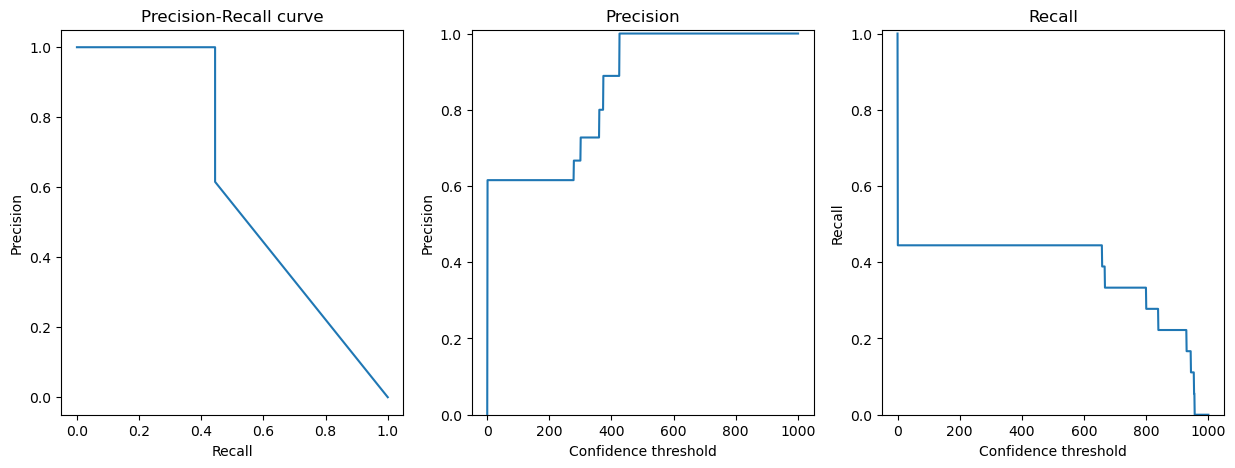

ULTRALYTICS


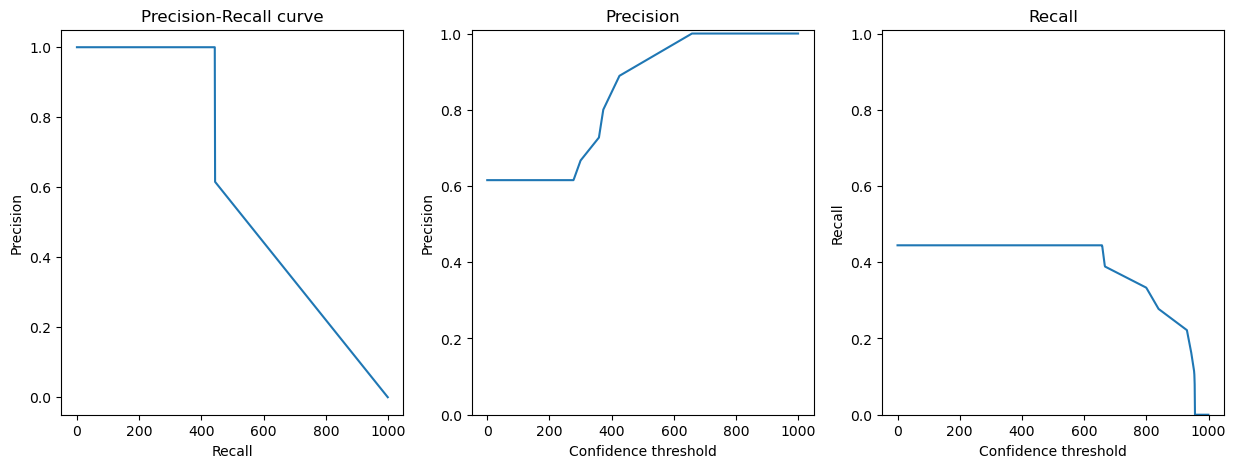

OUR


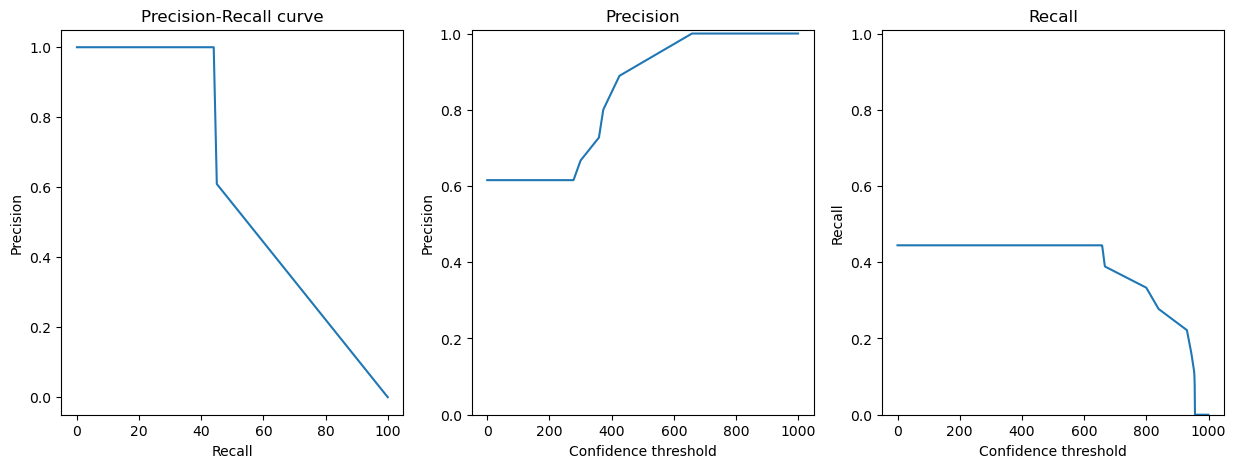

YOLO


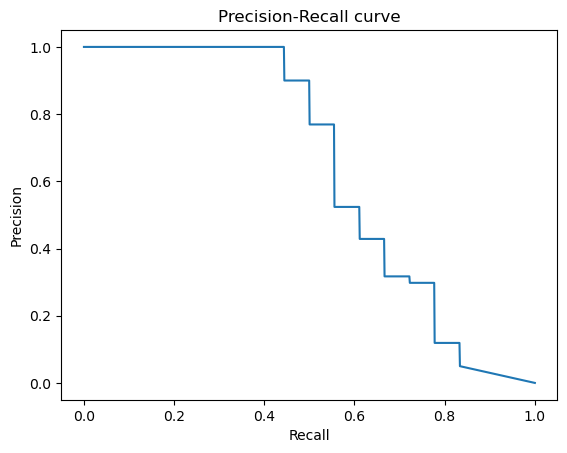

AP50 (basic): [0.4444444444444444]
AP50 (ultralytics): 0.6156
AP50 (nasza funkcja): [0.6155846153846154]
AP50 (YOLO): 0.6342


In [17]:
iou_thresholds = [0.5]

# Oblicz AP50 bez interpolacji
print("BASIC")
pred_boxes_all_images, gt_boxes_all_images = get_data(ds_path)
# ap50_basic =  calculate_ap_basic(gt_boxes_all_images[0], pred_boxes_all_images[0], iou_threshold=0.5, verb=True)
ap50_basic = mean_ap(gt_boxes_all_images, pred_boxes_all_images, calculate_ap_basic, iou_thresholds, verb=True)

# Oblicz AP50 z funkcji ultralytics
print("ULTRALYTICS")
tps = []

for threshold in iou_thresholds:
    tp, _, conf = get_tp(pred_boxes_all_images[0], gt_boxes_all_images[0], threshold)
    tps.append(tp)

tps = np.array(tps).T    

ap50_yolo_internal = ap_per_class_ultralytics(tps, conf,
                        np.ones(len(pred_boxes_all_images[0])), 
                        np.ones(len(gt_boxes_all_images[0])), 
                        plot = True)

# Oblicz AP50 z naszej funkcji
print("OUR")
# ap50_our = calculate_ap(tp, conf, len(pred_boxes_all_images[0]), len(gt_boxes_all_images[0]), verb=True)
ap50_our = mean_ap(gt_boxes_all_images, pred_boxes_all_images, calculate_ap, iou_thresholds, verb=True)

print("YOLO")
plt.plot(results.curves_results[0][0], results.curves_results[0][1][0])
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title("Precision-Recall curve")
plt.show()

print(f"AP50 (basic): {ap50_basic[0]}")
print(f"AP50 (ultralytics): {ap50_yolo_internal.item():.4f}")
print(f"AP50 (nasza funkcja): {ap50_our[0]}")
print(f"AP50 (YOLO): {ap50_yolo:.4f}")
